In [1]:
# ============================
# CLARITy — End-to-end Training + EVAL (EfficientNet) - PyTorch
# Multi-label chest X-ray classification with anti-overfitting strategies
# ============================

# ----------------------------
# 0. Edit paths
# ----------------------------
BASE_DIR = r"D:\Projects\CLARITY\Model\Dataset\archive"   # root containing folders image_001/... each with "images" subfolder
CSV_PATH = r"D:\Projects\CLARITY\Model\Dataset\archive\Data_Entry_2017.csv"  # metadata CSV
OUTPUT_DIR = r"./outputs"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [2]:
# ----------------------------
# 1. Imports
# ----------------------------
import json, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, auc, multilabel_confusion_matrix, precision_recall_curve
)

# Grad-CAM
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
except Exception:
    print("Install 'grad-cam' if you want Grad-CAM visualization: pip install grad-cam")

In [3]:
# ----------------------------
# 2. Reproducibility + device
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [4]:
# ----------------------------
# 3. Utility classes/functions
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0, path=None):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.path:
                torch.save(model.state_dict(), self.path)
                if self.verbose:
                    print(f"Saved checkpoint to {self.path}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', logits=True):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.logits = logits
    def forward(self, inputs, targets):
        if self.logits:
            bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            bce = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        loss = self.alpha * (1-pt)**self.gamma * bce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

def save_history(history, path):
    with open(path, 'w') as f:
        json.dump(history, f, indent=2)

CSV rows: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,NoFinding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


Detected classes: 15
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'NoFinding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


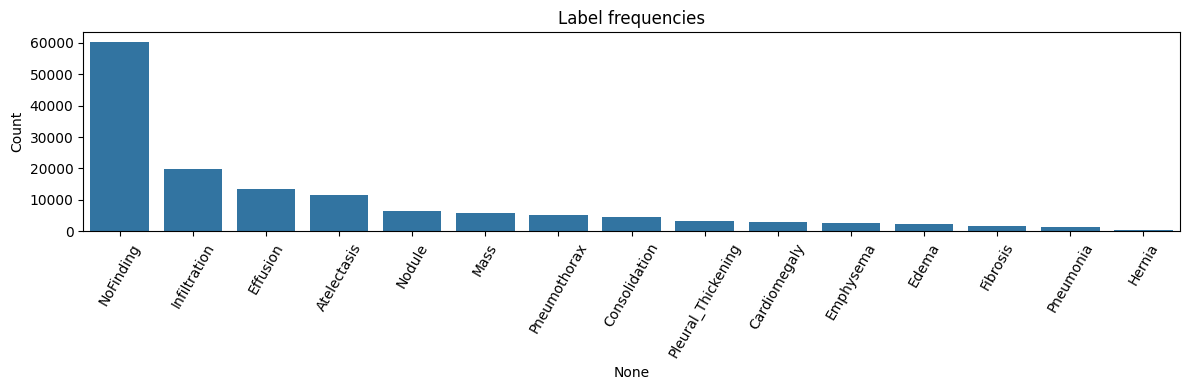

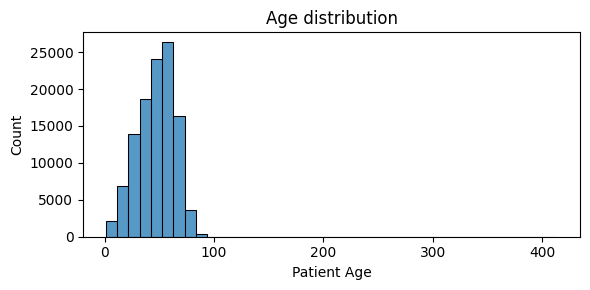

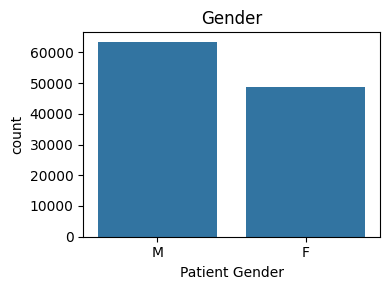

In [5]:
# ----------------------------
# 4. Load CSV and EDA
# ----------------------------
df = pd.read_csv(CSV_PATH)
df['Finding Labels'] = df['Finding Labels'].astype(str).apply(lambda x: x.replace(" ", ""))
print("CSV rows:", len(df))
display(df.head())

# Unique labels
all_labels = sorted(set([lab for group in df['Finding Labels'].tolist() for lab in group.split('|')]))
print("Detected classes:", len(all_labels))
print(all_labels)

# Label frequency plot
mlb_temp = MultiLabelBinarizer(classes=all_labels)
y = mlb_temp.fit_transform(df['Finding Labels'].str.split('|'))
label_counts = pd.Series(y.sum(axis=0), index=mlb_temp.classes_).sort_values(ascending=False)
plt.figure(figsize=(12,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=60); plt.title("Label frequencies"); plt.ylabel("Count"); plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR)/"label_freq.png", dpi=150); plt.show()

# Age & Gender distribution
if 'Patient Age' in df.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(df['Patient Age'].dropna().astype(float), bins=40)
    plt.title('Age distribution'); plt.tight_layout(); plt.savefig(Path(OUTPUT_DIR)/"age_dist.png", dpi=150); plt.show()
if 'Patient Gender' in df.columns:
    plt.figure(figsize=(4,3))
    sns.countplot(x='Patient Gender', data=df)
    plt.title('Gender'); plt.tight_layout(); plt.savefig(Path(OUTPUT_DIR)/"gender_count.png", dpi=150); plt.show()

In [6]:
# ----------------------------
# 5. Cache image paths
# ----------------------------
print("Caching image paths...")
img_map = {}
root = Path(BASE_DIR)
for sub in root.iterdir():
    if not sub.is_dir(): continue
    images_dir = sub / "images"
    if not images_dir.exists(): continue
    for p in images_dir.iterdir():
        if p.suffix.lower() in ('.png', '.jpg', '.jpeg'):
            img_map[p.name] = str(p)
print("Cached images:", len(img_map))
df['exists'] = df['Image Index'].apply(lambda x: x in img_map)
df = df[df['exists']].reset_index(drop=True)
print("After filtering missing images:", len(df))

Caching image paths...
Cached images: 112120
After filtering missing images: 112120


In [7]:
# ----------------------------
# 6. Label binarization & sample weights
# ----------------------------
mlb = MultiLabelBinarizer(classes=all_labels)
labels_bin = mlb.fit_transform(df['Finding Labels'].str.split('|'))
for i, c in enumerate(mlb.classes_):
    df[c] = labels_bin[:, i]

# Sample weights for WeightedRandomSampler
class_counts = labels_bin.sum(axis=0)
inv_class_freq = 1.0 / (class_counts + 1e-6)
sample_weights = []
for row in labels_bin:
    sample_weights.append(float((inv_class_freq * row).sum()) if row.sum()>0 else 1.0)
sample_weights = np.array(sample_weights)
sample_weights = sample_weights / np.mean(sample_weights)

In [8]:
# ----------------------------
# 7. Train/Val/Test split (multi-label safe)
# ----------------------------
# If 'Patient ID' exists, split by patient
if 'Patient ID' in df.columns:
    unique_patients = df['Patient ID'].unique()
    train_patients, temp_patients = train_test_split(unique_patients, test_size=0.2, random_state=SEED)
    val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=SEED)

    train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
    val_df   = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
    test_df  = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)
else:
    # Fallback: stratify by single most frequent label
    df['primary_label'] = df[mlb.classes_].idxmax(axis=1)
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['primary_label'])
    val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['primary_label'])
    train_df = train_df.reset_index(drop=True)
    val_df   = val_df.reset_index(drop=True)
    test_df  = test_df.reset_index(drop=True)

print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))

# Drop temporary column if created
if 'primary_label' in df.columns:
    df.drop(columns=['primary_label'], inplace=True)

Train/Val/Test sizes: 89826 10930 11364


In [9]:
# ----------------------------
# 8. Dataset & DataLoader
# ----------------------------
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 0

train_transforms = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.08, contrast=0.08)], p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class CLARITYDataset(Dataset):
    def __init__(self, df, img_map, classes, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_map = img_map
        self.transform = transform
        self.classes = classes
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = self.img_map[row['Image Index']]
        img = Image.open(path).convert('RGB')
        if self.transform: img = self.transform(img)
        labels = torch.tensor(row[self.classes].values.astype(np.float32))
        return img, labels

train_dataset = CLARITYDataset(train_df, img_map, mlb.classes_, train_transforms)
val_dataset = CLARITYDataset(val_df, img_map, mlb.classes_, val_transforms)
test_dataset = CLARITYDataset(test_df, img_map, mlb.classes_, val_transforms)

# Compute sample weights for WeightedRandomSampler
labels_bin_train = train_df[mlb.classes_].values
class_counts = labels_bin_train.sum(axis=0)
inv_class_freq = 1.0 / (class_counts + 1e-6)

sample_weights = []
for row in labels_bin_train:
    if row.sum() == 0:
        sample_weights.append(1.0)
    else:
        sample_weights.append(float((inv_class_freq * row).sum()))
sample_weights = np.array(sample_weights)
sample_weights = sample_weights / np.mean(sample_weights)

sampler = WeightedRandomSampler(sample_weights.tolist(), num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [10]:
# ----------------------------
# 9. Model, loss, optimizer, scheduler
# ----------------------------
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = efficientnet_b3(weights=weights)
in_ch = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_ch, len(mlb.classes_))
)
model = model.to(DEVICE)

# Loss
use_focal = True
pos_weight = torch.tensor((class_counts.max() / (class_counts + 1e-6))).float().to(DEVICE)
criterion = FocalLoss(alpha=1.0, gamma=2.0, logits=True) if use_focal else nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer & scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Early stopping
checkpoint_path = Path(OUTPUT_DIR)/"best_model.pth"
es = EarlyStopping(patience=5, verbose=True, path=str(checkpoint_path))

In [11]:
# ----------------------------
# 10. Training loop (mixed precision + checkpoint + history)
# ----------------------------
EPOCHS = 30
history = {'train_loss':[], 'val_loss':[], 'val_auc':[], 'val_f1':[]}
scaler = torch.amp.GradScaler(enabled=(DEVICE.type=='cuda'))

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    # Train
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        if scaler:
            with torch.amp.autocast(device_type=DEVICE.type):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_probs, all_targets = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item() * imgs.size(0)
            all_probs.append(torch.sigmoid(outputs).cpu().numpy())
            all_targets.append(labels.cpu().numpy())
    epoch_val_loss = val_loss / len(val_loader.dataset)
    history['val_loss'].append(epoch_val_loss)
    all_probs, all_targets = np.vstack(all_probs), np.vstack(all_targets)

    # Metrics
    try: val_auc = roc_auc_score(all_targets, all_probs, average='macro')
    except: val_auc = float('nan')
    y_pred_bin = (all_probs > 0.5).astype(int)
    val_f1 = f1_score(all_targets, y_pred_bin, average='macro', zero_division=0)
    history['val_auc'].append(float(val_auc))
    history['val_f1'].append(float(val_f1))

    scheduler.step(epoch_val_loss)
    es(epoch_val_loss, model)
    if es.early_stop: 
        print("Early stopping triggered"); break

    t1 = time.time()
    print(f"Epoch {epoch}: Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}, Val F1={val_f1:.4f}, Val AUC={val_auc:.4f}, Time={(t1-t0)/60:.2f} min")

save_history(history, Path(OUTPUT_DIR)/"training_history.json")
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss curves')
plt.savefig(Path(OUTPUT_DIR)/"loss_curves.png", dpi=150); plt.show()

Epoch 1/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5615/5615 [29:32<00:00,  3.17it/s]


Saved checkpoint to outputs\best_model.pth
Epoch 1: Train Loss=0.0791, Val Loss=0.0724, Val F1=0.2242, Val AUC=0.7796, Time=32.80 min


Epoch 2/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5615/5615 [29:24<00:00,  3.18it/s]


Saved checkpoint to outputs\best_model.pth
Epoch 2: Train Loss=0.0659, Val Loss=0.0677, Val F1=0.2509, Val AUC=0.7730, Time=32.68 min


Epoch 3/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5615/5615 [30:48<00:00,  3.04it/s]


EarlyStopping counter: 1/5
Epoch 3: Train Loss=0.0566, Val Loss=0.0726, Val F1=0.2474, Val AUC=0.7596, Time=34.06 min


Epoch 4/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5615/5615 [33:24<00:00,  2.80it/s]


EarlyStopping counter: 2/5
Epoch 4: Train Loss=0.0492, Val Loss=0.0815, Val F1=0.2375, Val AUC=0.7493, Time=36.67 min


Epoch 5/30 [Train]: 100%|██████████████████████████████████████████████████████████| 5615/5615 [33:25<00:00,  2.80it/s]


EarlyStopping counter: 3/5
Epoch 5: Train Loss=0.0430, Val Loss=0.0813, Val F1=0.2287, Val AUC=0.7394, Time=36.70 min


Epoch 6/30 [Train]:  11%|██████▎                                                    | 595/5615 [03:35<30:17,  2.76it/s]


KeyboardInterrupt: 

In [ ]:
# ----------------------------
# 11. Load best model & evaluate on test set
# ----------------------------
model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
model.eval()
all_probs, all_targets = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        all_probs.append(torch.sigmoid(outputs).cpu().numpy())
        all_targets.append(labels.numpy())
all_probs, all_targets = np.vstack(all_probs), np.vstack(all_targets)

y_pred_bin = (all_probs > 0.5).astype(int)
report = classification_report(all_targets, y_pred_bin, target_names=mlb.classes_)
print(report)